<a href="https://colab.research.google.com/github/Praneet9/Pytorch-Learning/blob/master/Transfer_Learning_Torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [0]:
!git clone https://github.com/jaddoescad/ants-bees-dataset.git

In [0]:
transform_train = transforms.Compose([
                                transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose([
                                transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
training_dataset = datasets.ImageFolder('ants-bees-dataset/train', transform=transform_train)
validation_dataset = datasets.ImageFolder('ants-bees-dataset/val', transform=transform)

training_dataloader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=20, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=20, shuffle=False)

In [0]:
print(len(training_dataset))
print(len(validation_dataset))

244
153


In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [0]:
classes = ['ant', 'bee']

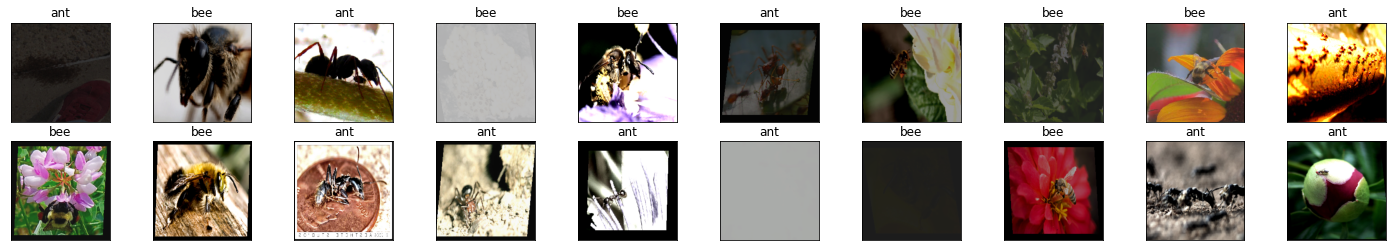

In [0]:
dataiter = iter(training_dataloader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in range(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks = [], yticks = [])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [0]:
model = models.alexnet(pretrained=True)

In [0]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
for param in model.features.parameters():
  param.requires_grad = False

In [0]:
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [0]:
epochs = 10
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  for inputs, labels in training_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)

    running_corrects += torch.sum(preds == labels.data).item()
    running_loss += loss.item()
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_dataloader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)

        val_running_corrects += torch.sum(val_preds == val_labels.data).item()
        val_running_loss += val_loss.item()


    epoch_loss = running_loss / len(training_dataloader.dataset)
    epoch_acc = running_corrects / len(training_dataloader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss / len(validation_dataloader.dataset)
    val_epoch_acc = val_running_corrects / len(validation_dataloader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print(f'Epoch:{e+1} Training Loss: {round(epoch_loss, 4)} Training Accuracy: {round(epoch_acc, 4)} Validation Loss: {round(val_epoch_loss, 4)} Validation Accuracy: {round(val_epoch_acc, 4)}')

Epoch:1 Training Loss: 0.0332 Training Accuracy: 0.6557 Validation Loss: 0.02 Validation Accuracy: 0.8497
Epoch:2 Training Loss: 0.0265 Training Accuracy: 0.7172 Validation Loss: 0.0219 Validation Accuracy: 0.8235
Epoch:3 Training Loss: 0.0247 Training Accuracy: 0.7787 Validation Loss: 0.0226 Validation Accuracy: 0.8366
Epoch:4 Training Loss: 0.0231 Training Accuracy: 0.7787 Validation Loss: 0.0153 Validation Accuracy: 0.8889
Epoch:5 Training Loss: 0.0219 Training Accuracy: 0.7951 Validation Loss: 0.0165 Validation Accuracy: 0.8954
Epoch:6 Training Loss: 0.0188 Training Accuracy: 0.8197 Validation Loss: 0.0195 Validation Accuracy: 0.8431
Epoch:7 Training Loss: 0.0208 Training Accuracy: 0.8279 Validation Loss: 0.022 Validation Accuracy: 0.8693
Epoch:8 Training Loss: 0.0208 Training Accuracy: 0.8115 Validation Loss: 0.0207 Validation Accuracy: 0.8627
Epoch:9 Training Loss: 0.021 Training Accuracy: 0.8238 Validation Loss: 0.0213 Validation Accuracy: 0.8693
Epoch:10 Training Loss: 0.0186 T

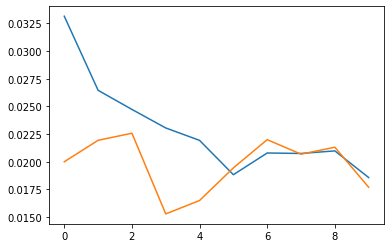

In [0]:
plt.plot(running_loss_history, label='Training Loss')
plt.plot(val_running_loss_history, label='Validation Loss')
plt.show()

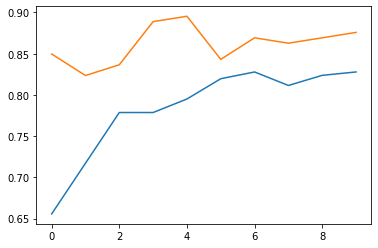

In [0]:
plt.plot(running_corrects_history, label='Training Accuracy')
plt.plot(val_running_corrects_history, label='Validation Accuracy')
plt.show()